<a href="https://colab.research.google.com/github/LindaZacarias/Eviews/blob/main/Sarima_Exportaciones_Peruanas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo Sarima de Exportaciones Peruanas**
## **Examen Final de Econometria Intermédia**
---
> Presentado por: Linda Zacarias Espinoza



# **EXPORTACIONES**
Desde 2007 hasta 2025, las exportaciones peruanas experimentaron un crecimiento significativo, destacando repuntes en 2007 y 2012 cuando se registraron montos de US 28 mil millones y US$46 mil millones respectivamente. Durante este período, la economía exportadora se benefició de altos precios internacionales de bienes primarios, en particular los minerales, aunque con fluctuaciones marcadas por la coyuntura global, sobre todo en 2008-2009 y durante la pandemia de 2020.

A nivel mensual, los envíos han mostrado aumentos y caídas alineadas a la estacionalidad minera y agrícola, alcanzando un máximo histórico de US 7,657 millones en noviembre de 2024. Posteriormente, se evidenció una ligera desaceleración, aunque en mayo de 2025 las exportaciones rondaron los US 6,162 millones. Las proyecciones apuntan a un valor alrededor de US 6,700 millones mensuales en 2026, manteniéndose la importancia de los minerales y la recuperación de volúmenes luego de periodos de menor dinamismo.

En cuanto a participación global, Perú incrementó su cuota de exportaciones de bienes y servicios en el mercado mundial, llegando a un máximo de 0.276% en 2025, un notable avance respecto al 0.223% de mediados de la década de 2000. A pesar de los desafíos internacionales y políticas comerciales, la tendencia general fue de expansión exportadora sostenida con resiliencia ante shocks externos, consolidando el sector como motor clave de la economía nacional.

[MacroTrends](https://www.macrotrends.net/global-metrics/countries/per/peru/exports)

[TradingEconomics](https://tradingeconomics.com/peru/exports)

[CEICDATA](https://www.ceicdata.com/en/peru/trade-statistics-share-in-world-trade-and-performance-indicators-forecast-non-oecd-member-annual/share-in-world-exports-value-exports-good-and-services-expressed-in-usd)





#Metodología basada en Box Jenkins (1987)



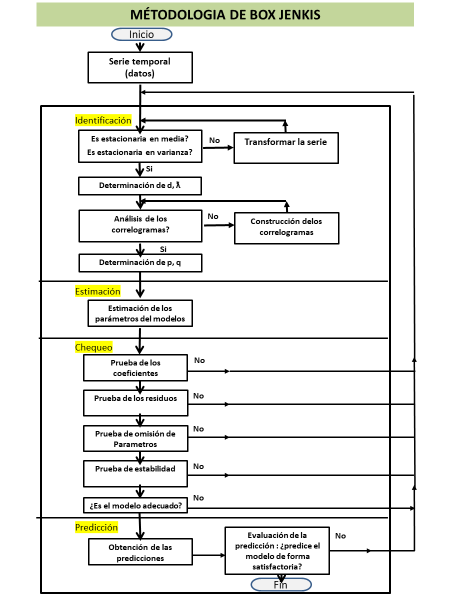

# 1. Instalación de paquetes e importación de librerías

In [ ]:
!pip install econdata

In [ ]:
!pip install plotly statsmodels pandas matplotlib

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from econdata import BCRP
import plotly.express as px
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# Reinstalar numpy y pmdarima para resolver problemas de compatibilidad
#!pip install --upgrade --force-reinstall numpy pmdarima
#!pip install --upgrade --force-reinstall numpy==1.26.4 pandas==2.2.2 pmdarima==2.0.4

# 2. Acceso a la data mediante conexión a series del BCRP

Datos del Banco Central del Perú (BCRP)
Producción de limón: PN01788AM


In [ ]:
df = BCRP.get_data(
    series={'PN38714BM':'Exportaciones'},
    fechaini='2007-01-01',
    fechafin='2025-31-05'
)
df

,Exportaciones
2007-01-01,1747.482809
2007-02-01,1907.756777
2007-03-01,2099.541197
2007-04-01,2119.749863
2007-05-01,2144.563295
...,...
2025-01-01,7086.673662
2025-02-01,6480.679506
2025-03-01,7219.729742
2025-04-01,5927.653410


# 3. Análisis gráfico de la serie de tiempo

In [ ]:
fig = px.line(df, x=df.index, y=['Exportaciones'],
              title='Perú. Evolución de las Exportaciones. 2007.01-2025.05 (Expresado en millones US$)', template='plotly')
fig.update_xaxes(
    title_text=None,
    ticklabelposition="inside top",
    rangeslider_visible=True,
    rangeselector=dict(
        x=0,
        xanchor="auto",
        y=1,
        yanchor="bottom",
        buttons=list([
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(count=15, label="15y", step="year", stepmode="todate"),
            dict(step="all")
        ]),
        font=dict(
            color="#111111",
            size=13,
            family="Arial",
            ),
        visible=True,
    )
)
fig.update_yaxes(
    title_text='Millones US$'
)
fig.show();

Se visualiza que las exportaciones peruanas presentan una tendencia creciente con fluctuaciones significativas a lo largo del periodo 2007–2025. Se observa un comportamiento cíclico con picos y caídas marcados, especialmente influenciados por los precios internacionales de los commodities y factores externos.

Entre 2007 y 2014, las exportaciones muestran una etapa de crecimiento sostenido, alcanzando un primer pico en 2012. Luego, entre 2014 y 2016, se visualiza una caída progresiva, atribuida en parte a la desaceleración de los precios de los metales y al entorno económico internacional.

A partir de 2017, se aprecia una recuperación gradual, interrumpida de forma abrupta en 2020 debido al impacto de la pandemia por COVID-19. Esta caída se destaca por ser una de las más profundas del periodo, seguida de una rápida recuperación en 2021 y un crecimiento notable hasta mediados de 2022.

Posteriormente, desde 2023, se perciben fluctuaciones más marcadas, con una posible desaceleración o ajuste hacia el 2025. Se evidencia también un comportamiento estacional en los valores exportados, lo que sugiere la influencia de ciclos productivos o de demanda externa.

# 4. Desarrollando el modelo ARIMA

4.1 División de datos en grupos de entrenamiento (train) y validación (test)

Fechas entrenamiento : 2007-01-01 00:00:00 --- 2024-12-01 00:00:00  (n=216)
Fechas prueba  : 2025-01-01 00:00:00 --- 2025-05-01 00:00:00  (n=5)
 



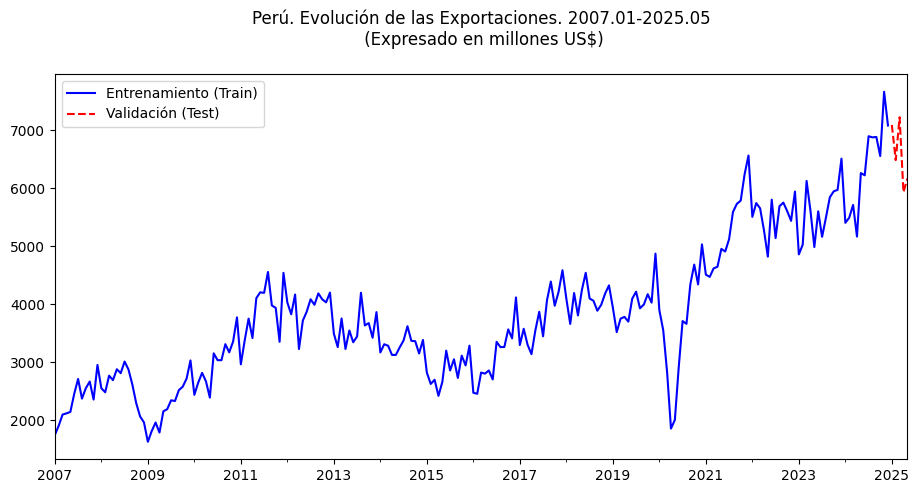

In [ ]:
# Fechas Train-test
# ======================================================================================
fin_train = '2024-12-31 00:00:00'
print(
    f"Fechas entrenamiento : {df.index.min()} --- {df.loc[:fin_train].index.max()}  "
    f"(n={len(df.loc[:fin_train])})"
)
print(
    f"Fechas prueba  : {df.loc[fin_train:].index.min()} --- {df.loc[:].index.max()}  "
    f"(n={len(df.loc[fin_train:])})"
)
datos_train = df['Exportaciones'].loc[:fin_train]
datos_test  = df['Exportaciones'].loc[fin_train:]

# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(11, 5))
datos_train.plot(ax=ax, label='Entrenamiento (Train)', color='blue')
datos_test.plot(ax=ax, label='Validación (Test)', color='red', linestyle='--')
#ax.axvline(x=fin_train, color='gray', linestyle='--')
ax.set_title('Perú. Evolución de las Exportaciones. 2007.01-2025.05\n (Expresado en millones US$)\n')
ax.legend()
print(" \n");

# 4.2 Análisis exploratorio

4.2.1 Prueba de estacionariedad

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -0.329520374989461, p-value: 0.9212180556283112

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------------
ADF Statistic: -4.447107467359223, p-value: 0.00024475283118141514
 



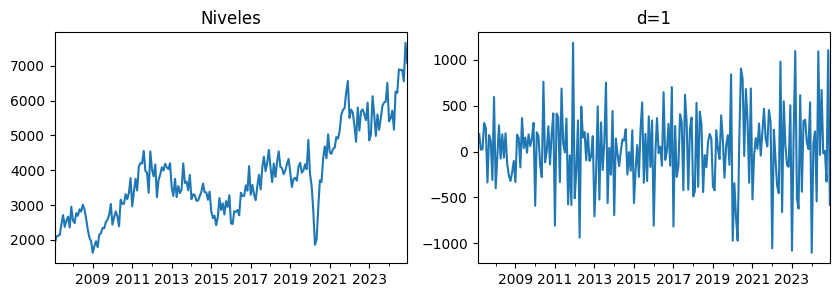

In [ ]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = datos_train.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(df)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

warnings.filterwarnings("default")

# Gráfico series | Funciones de autocorrelación y autocorrelación parcial
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), sharex=True)
df['Exportaciones'].plot(ax=axs[0], title='Niveles')
datos_diff_1.plot(ax=axs[1], title='d=1')
print(" \n");

4.2.2 Análisis de Autocorrelación

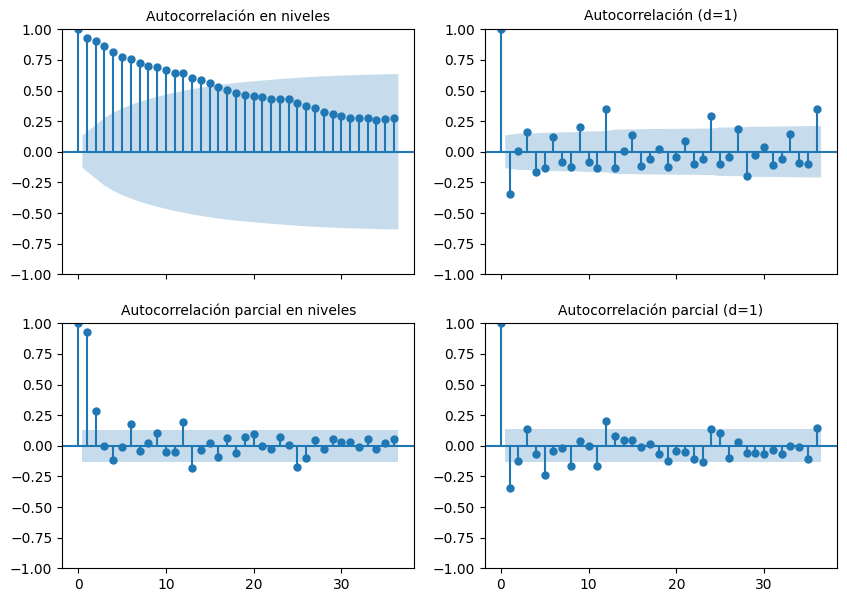

In [ ]:
# Autocorrelación y autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 7), sharex=True)
plot_acf(df, ax=axs[0,0], lags=36, alpha=0.05)
axs[0,0].set_title('Autocorrelación en niveles', fontsize=10)
plot_acf(datos_diff_1, ax=axs[0,1], lags=36, alpha=0.05)
axs[0,1].set_title('Autocorrelación (d=1)', fontsize=10)
plot_pacf(df, ax=axs[1,0], lags=36, alpha=0.05)
axs[1,0].set_title('Autocorrelación parcial en niveles', fontsize=10)
plot_pacf(datos_diff_1, ax=axs[1,1], lags=36, alpha=0.05)
axs[1,1].set_title('Autocorrelación parcial (d=1)', fontsize=10);

4.2.3 Descomposición de la serie

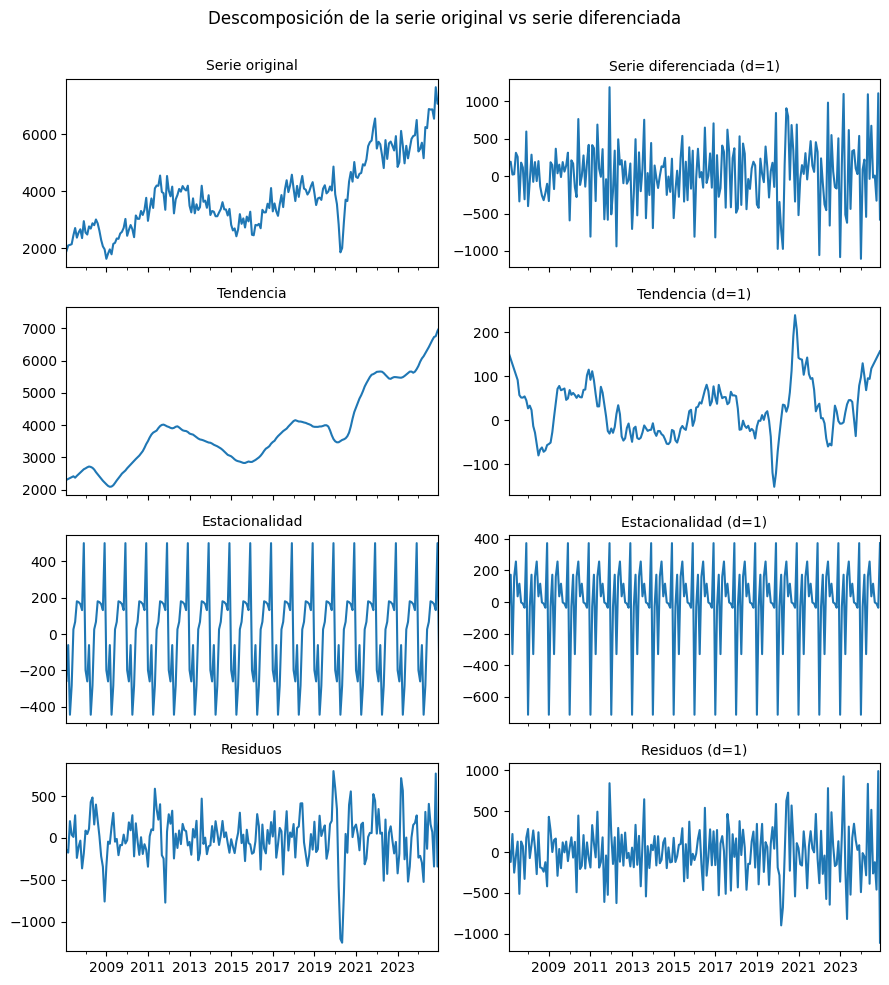

In [ ]:
# Descomposición de la serie original y la serie diferenciada
# ==============================================================================
res_decompose = seasonal_decompose(df, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 10), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=10)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=10)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=10)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=10)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Serie diferenciada (d=1)', fontsize=10)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia (d=1)', fontsize=10)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad (d=1)', fontsize=10)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos (d=1)', fontsize=10)
fig.suptitle('Descomposición de la serie original vs serie diferenciada\n', fontsize=12)
fig.tight_layout();

4.2.4 Estacionariedad de serie diferenciada

In [ ]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# ==============================================================================
datos_diff_1_12 = datos_train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -6.028445060420266, p-value: 1.4370790975080208e-07


# 4.3 Modelo ARIMA-SARIMAX

In [ ]:
!pip install pmdarima --quiet

In [ ]:
from pmdarima import auto_arima

In [ ]:
smodel = pm.auto_arima(datos_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=12,             # frequency of series
                      d=1,              # let model determine 'd'
                      seasonal=True,    # Yes Seasonality
                      start_P=1,
                      D=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2961.292, Time=1.30 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3075.745, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3011.213, Time=0.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.49 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(1,1,0)[12]             : AIC=3013.154, Time=1.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(2,1,1)[12]             : AIC=2961.617, Time=5.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=7.29 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=3062.074, Time=0.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2961.131, Time=3.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=0.89 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,1)(0,1,2)[12]             : AIC=inf, Time=2.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(0,1,2)[12]             : AIC=inf, Time=3.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(0,1,2)[12]             : AIC=inf, Time=1.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,0)(0,1,2)[12]             : AIC=2961.122, Time=2.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=2.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,0)(1,1,1)[12]             : AIC=2961.284, Time=0.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,0)(0,1,2)[12]             : AIC=2963.019, Time=2.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(3,1,1)(0,1,2)[12]             : AIC=2965.122, Time=1.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,1,0)(0,1,2)[12] intercept   : AIC=2962.953, Time=3.07 sec

Best model:  ARIMA(2,1,0)(0,1,2)[12]          
Total fit time: 43.942 seconds


In [ ]:
print(smodel.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  216
Model:             SARIMAX(2, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -1475.561
Date:                                 Sat, 02 Aug 2025   AIC                           2961.122
Time:                                         00:18:23   BIC                           2977.688
Sample:                                     01-01-2007   HQIC                          2967.824
                                          - 12-01-2024                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3361      0.058     -5.747      0.000      -0.451      -0

#**La corrida del modelo**

1.   El **valor de AIC (Akaike Information Criterium) es 2765.779**, lo cual **sugiere un buen ajuste del modelo**, aunque no es necesariamente el mejor posible, lo normal para un buen modelo debe ser negativo y de un mínimo valor.
2.   El **valor de BIC (Bayesian Information Criterial) es 2775.536**. Este criterio penaliza más fuertemente los modelos con muchos parámetros un menor valor de BIC indica un mejor modelo en comparación relativa. **Este valor sugiere que el modelo es adecuado, pero sugiere explorar otros modelos más simples si se desea reducir la complejidad.**
3. El valor del **HQIC (Hannan-Quinn Information Criterion) es 2769.731**, el cual también es útil para comparar modelos.** Este criterio penaliza la complejidad de forma intermedia entre AIC y BIC**. Un valor más bajo indicaría un modelo más eficiente.
4. El **modelo SARIMAX(0,1,1)**, cuando p=0 significa que no hay autoregresión, cuando d=1 tiene una diferencia no estacional, cuando q=1 significa que hay un promedio movil no estacional (MA), P = 0 indica que no hay componente autorregresivo estacional,solo (MA) y diferenciación, D = 1 significa que se aplicó una diferenciación estacional, es decir, se eliminó la estacionalidad anual, Q = 1 señala que existe un componente de media móvil estacional, el periodo estacional es de 12 meses.
5. Cantidad de observaciones 204.
6. Log **Likelihood es -1379.890**, y esto significa que a compaparación de otros modelos este es el mejor de todos (el menorlikelihood de todos)
7. **ma.L1 = -0.2559 significa que existe una relación negativa entre el error del periodo anterior y el valor actual de la serie**, es estadísticamente significativo (p-valor = 0.000), lo que significa que su efecto es relevante.
8. **ma.S.L12 = -0.8555 significa que hay una fuerte corrección negativa del error estacional del periodo anterior**, también altamente significativo.
10.** sigma2 = 101,700 (aprox)** tiene el **valor positivo y significativ**o, esto sirve para saber qué tan dispersos son los errores del modelo.




### **Modelo SARIMA(0,1,1)(0,1,1)[12] en forma larga**

El modelo estimado es:

$$(1 - \phi_{12} L^{12})(1 - L)Y_t = (1 + \theta_1 L)(1 + \Theta_{12} L^{12})\varepsilon_t$$

Sustituyendo los coeficientes estimados:

$$(1 - L^{12})(1 - L)Y_t = (1 - 0.2559 L)(1 - 0.8555 L^{12})\varepsilon_t$$

Donde:

- $Y_t$ : Serie de exportaciones en el tiempo $t$  
- $L$ : Operador rezago  
- $\varepsilon_t$ : Término de error aleatorio con media cero y varianza constante.



# **CHEQUEO**

1. Tenemos la **prueba de Ljung-Box (Q) de valor 0.00** con una **probabilidad de 0.95** lo cual indica que **no existe autocorrelación entre los residuos**.

2. Tambien se tiene la prueba de **Heterocedasticidad** donde la probabilidad asociada al **valor de 2.09** tiene una **probabilidad de 0.00** porlo que se sabe que **hay heterocedasticidad**, puesto que los errores cambian su varianza a lo largo del tiempo, esto afecta la eficiencia de los estimadores, aunque no necesariamente su consistencia.

3. Seguidamente se tiene la prueba de la **normalidad de los residuos** que alcanza una **probabilidad de 0.01**, al ser este menor que 0.05 indica que **no existe normalidad en los residuos.**

4. la **asimetría** alcanza un **valor de 0.01** lo que indica que es **casi simétrica** puesto que tiene un **valor cercano a 0**.

5. La **Kurtosis** con un **valor de 4.08** esta por **encima de 3**, **tienen colas pesadas**, es decir, con **distribución leptocurtica** ocurren más valores extremos de lo que se esperaría si los errores fueran normales. Esto puede afectar la precisión estadística del modelo, pero no necesariamente invalida tus resultados, especialmente si lo usas para predicción.

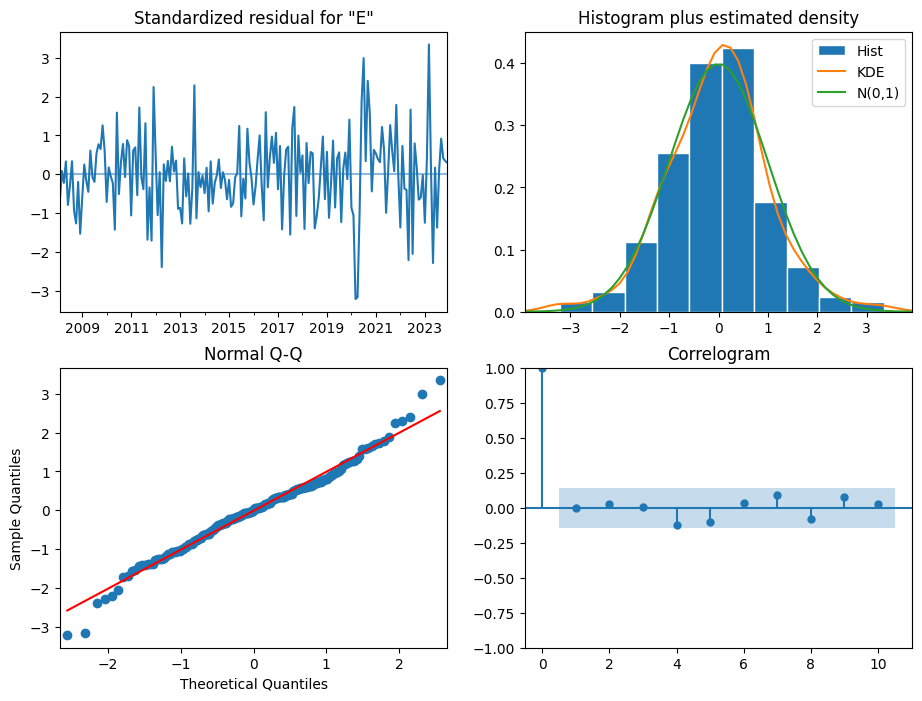

In [ ]:
modelo_res.plot_diagnostics(figsize=(11, 8))
plt.show();

In [ ]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=30).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(30))

,predicciones_statsmodels
2024-01-01,5737.175067
2024-02-01,5713.056460
2024-03-01,5926.651215
2024-04-01,5599.593634
2024-05-01,5610.421440
2024-06-01,6019.795930
2024-07-01,5967.029317
2024-08-01,6176.765597
2024-09-01,6281.897165
2024-10-01,6334.568589


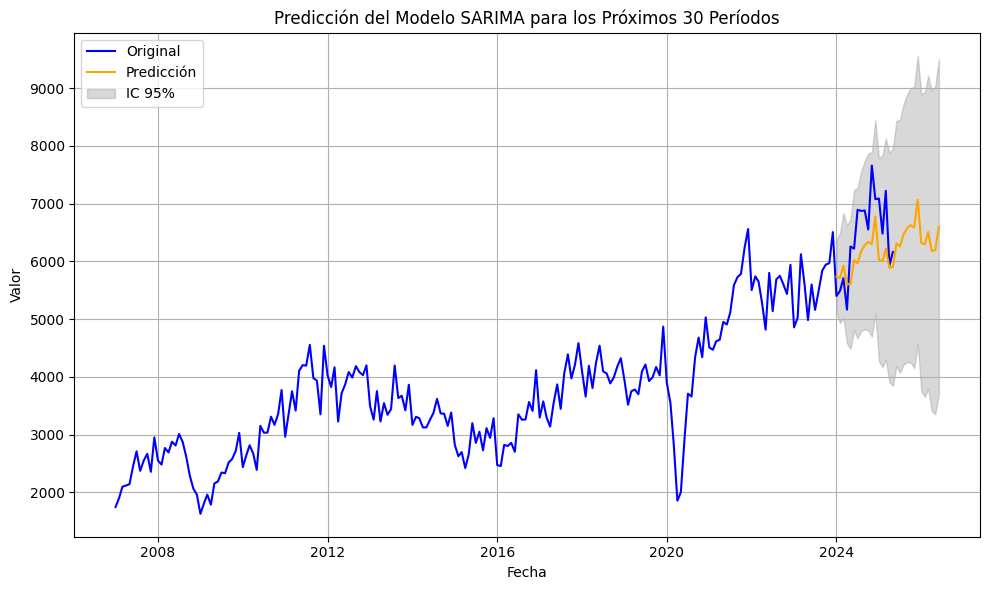

In [ ]:
import matplotlib.pyplot as plt

# Hacer la predicción de los próximos 30 periodos
predicciones = modelo_res.get_forecast(steps=30)

# Obtener la media y los intervalos de confianza
prediccion_media = predicciones.predicted_mean
intervalos_confianza = predicciones.conf_int()

# Graficar la serie original y la predicción
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Exportaciones'], label='Original', color='blue')
plt.plot(prediccion_media.index, prediccion_media, label='Predicción', color='orange')

# Rellenar los intervalos de confianza
plt.fill_between(prediccion_media.index,
                 intervalos_confianza.iloc[:, 0],
                 intervalos_confianza.iloc[:, 1],
                 color='gray', alpha=0.3, label='IC 95%')

# Título actualizado con "30 Períodos"
plt.title('Predicción del Modelo SARIMA para los Próximos 30 Períodos')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#**PREDICCIÓN**

La gráfica muestra la evolución de las exportaciones peruanas desde el año 2007 hasta mayo de 2025, junto con una proyección de los próximos 30 meses utilizando un modelo SARIMA(0,1,1)(0,1,1)[12], que incorpora efectos estacionales anuales.

Durante el periodo histórico, se observa una tendencia creciente con variaciones notables, en especial en los años recientes. Cabe destacar la fuerte caída del año 2020, atribuida a los efectos del COVID-19, seguida de una recuperación sostenida hasta el 2022, año en que las exportaciones alcanzaron niveles récord por el alza de los precios de minerales como el cobre, el oro y el gas natural, principales productos de exportación del Perú.

La línea naranja representa la predicción del modelo para el período junio 2025 a noviembre 2027, mientras que la banda gris señala el intervalo de confianza al 95%. El modelo proyecta un comportamiento relativamente estable con ligera tendencia a la recuperación moderada, manteniéndose en torno a los 6,000–7,000 millones de dólares mensuales, aunque con cierta volatilidad estacional, propia de las fluctuaciones en la demanda internacional.

El intervalo de confianza amplio refleja la incertidumbre macroeconómica global y la alta sensibilidad del Perú a los precios internacionales de materias primas, así como a factores como el tipo de cambio, condiciones climáticas (Fenómeno del Niño) y conflictos geopolíticos que pueden afectar tanto la producción como la logística de exportación.

En términos reales, estas predicciones se alinean con las proyecciones del Banco Central de Reserva del Perú (BCRP) y el Ministerio de Comercio Exterior y Turismo (MINCETUR), que anticipan que las exportaciones peruanas podrían estabilizarse tras la fuerte expansión postpandemia, aunque aún sujetas a los ciclos de los commodities y la transición hacia productos de mayor valor agregado.



In [ ]:
# Desinstalar las versiones existentes de numpy y pmdarima
#!pip uninstall numpy pmdarima -y
# Instalar versiones compatibles
#!pip install numpy==1.26.4 pmdarima==2.0.4